In [15]:
import sys
!{sys.executable} -m pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages (20.0.2)


In [18]:
import sys
!{sys.executable} -m pip install numpy reference matplotlib Pillow
!{sys.executable} -m pip install base props cython pandas mrcnn setuptools opencv-python tqdm 
!{sys.executable} -m pip install scikit-image seaborn sklearn keras==2.1.1 Pillow tensorflow==1.13.1

  Using cached tensorflow-1.13.1-cp37-cp37m-macosx_10_11_x86_64.whl (73.6 MB)
  Using cached tensorflow_estimator-1.13.0-py2.py3-none-any.whl (367 kB)
  Using cached tensorboard-1.13.1-py3-none-any.whl (3.2 MB)


  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from skimage.morphology import label
from skimage.io import imread

import os
import time
import sys

TRAINING_VALIDATION_RATIO = 0.2
WORKING_DIR = '../working'
INPUT_DIR = '../input'
OUTPUT_DIR = '../output'
LOGS_DIR = os.path.join(WORKING_DIR, "logs")
TRAIN_DATA_PATH = os.path.join(INPUT_DIR, 'train_v2')
TEST_DATA_PATH = os.path.join(INPUT_DIR, 'test_v2')
SAMPLE_SUBMISSION_PATH = os.path.join(INPUT_DIR, 'sample_submission_v2.csv')
TRAIN_SHIP_SEGMENTATIONS_PATH = os.path.join(INPUT_DIR, 'train_ship_segmentations_v2.csv')
MASK_RCNN_PATH = os.path.join(WORKING_DIR, 'Mask_RCNN-master')
COCO_WEIGHTS_PATH = os.path.join(WORKING_DIR, "mask_rcnn_coco.h5")
SHIP_CLASS_NAME = 'ship'
IMAGE_WIDTH = 768
IMAGE_HEIGHT = 768
SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT)

test_ds = os.listdir(TEST_DATA_PATH)
train_ds = os.listdir(TRAIN_DATA_PATH)

print('Working Dir:', WORKING_DIR, os.listdir(WORKING_DIR))
print('Input Dir:', INPUT_DIR, os.listdir(INPUT_DIR))
print('train dataset from: {}, {}'.format(TRAIN_DATA_PATH, len(train_ds)))
print('test dataset from: {}, {}'.format(TRAIN_DATA_PATH, len(test_ds)))
print(TRAIN_SHIP_SEGMENTATIONS_PATH)

Working Dir: ../working ['asdc_gpu20200401T1410', 'asdc_gpu20200401T1541', 'mask_rcnn_coco.h5', 'asdc_gpu20200401T1413', 'asdc_gpu20200401T1440', 'Mask_RCNN-master']
Input Dir: ../input ['.DS_Store', 'sample_submission_v2.csv', 'test_v2', 'train_v2', 'train_ship_segmentations_v2.csv']
train dataset from: ../input/train_v2, 192556
test dataset from: ../input/train_v2, 15606
../input/train_ship_segmentations_v2.csv


In [5]:

masks = pd.read_csv(TRAIN_SHIP_SEGMENTATIONS_PATH)
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


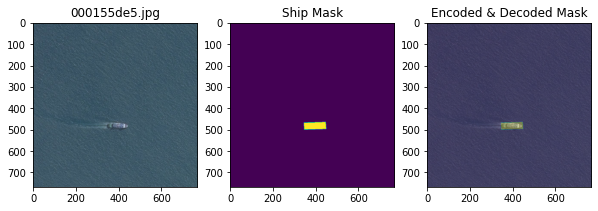

000155de5.jpg  Check Decoding->Encoding RLE_0: 1 -> RLE_1: 1


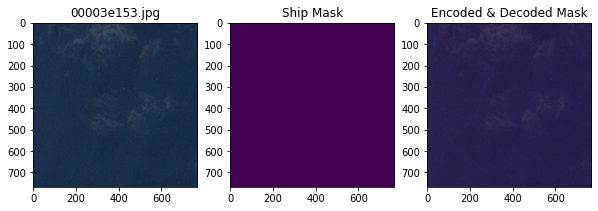

00003e153.jpg  Check Decoding->Encoding RLE_0: 1 -> RLE_1: 0
It could be different when there is no mask.


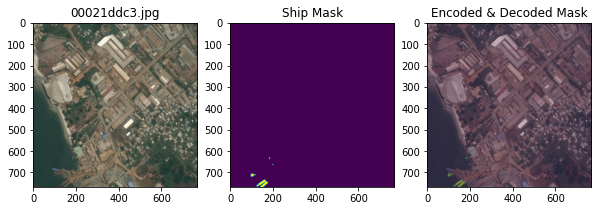

00021ddc3.jpg  Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
It could be different when there are masks overlapped.


In [6]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
  
    pixels = img.T.flatten() 
  
    pixels = np.concatenate([[0], pixels, [0]])
 
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  
    runs[1::2] -= runs[::2]
   
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=SHAPE):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def masks_as_image(in_mask_list, shape=SHAPE):
    all_masks = np.zeros(shape, dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def shows_decode_encode(image_id, path=TRAIN_DATA_PATH):
   
    fig, axarr = plt.subplots(1, 3, figsize = (10, 5))
    img_0 = imread(os.path.join(path, image_id))
    axarr[0].imshow(img_0)
    axarr[0].set_title(image_id)
    rle_1 = masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels']
    img_1 = masks_as_image(rle_1)
    axarr[1].imshow(img_1[:, :, 0])
    axarr[1].set_title('Ship Mask')
    rle_2 = multi_rle_encode(img_1)
    img_2 = masks_as_image(rle_2)
    axarr[2].imshow(img_0)
    axarr[2].imshow(img_2[:, :, 0], alpha=0.3)
    axarr[2].set_title('Encoded & Decoded Mask')
    plt.show()
    print(image_id , ' Check Decoding->Encoding',
          'RLE_0:', len(rle_1), '->',
          'RLE_1:', len(rle_2))

shows_decode_encode('000155de5.jpg')
shows_decode_encode('00003e153.jpg')
print('It could be different when there is no mask.')
shows_decode_encode('00021ddc3.jpg')
print('It could be different when there are masks overlapped.')

## Split Test and Validation datasets


unique_img_ids groupby took: 13.557622194290161


,ImageId,ships,RleMaskList
154320,cd3043b44.jpg,3,[35762 1 36528 4 37294 6 38060 9 38827 10 3959...
183977,f4a89b3dc.jpg,1,[24604 2 25372 2 26141 2 26909 2 27678 2 28446 1]
34536,2de36504a.jpg,11,[505580 1 506347 3 507114 6 507882 7 508649 9 ...


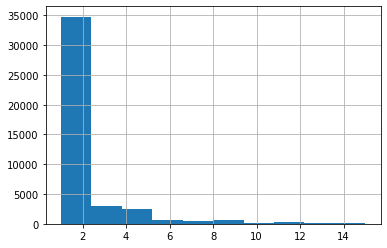

In [7]:

masks['ships'] = masks['EncodedPixels'].map(lambda encoded_pixels: 1 if isinstance(encoded_pixels, str) else 0)

start_time = time.time()
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'})
unique_img_ids['RleMaskList'] = masks.groupby('ImageId')['EncodedPixels'].apply(list)
unique_img_ids = unique_img_ids.reset_index()
end_time = time.time() - start_time
print("unique_img_ids groupby took: {}".format(end_time))
unique_img_ids = unique_img_ids[unique_img_ids['ships'] > 0]
unique_img_ids['ships'].hist()
unique_img_ids.sample(3)

34044 training masks
8512 validation masks


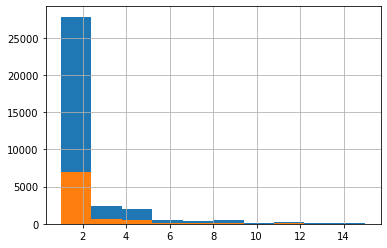

In [8]:

from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(unique_img_ids, 
                 test_size = TRAINING_VALIDATION_RATIO, 
                 stratify = unique_img_ids['ships'])
print(train_ids.shape[0], 'training masks')
print(val_ids.shape[0], 'validation masks')
train_ids['ships'].hist()
val_ids['ships'].hist()


In [9]:

UPDATE_MASK_RCNN = False

os.chdir(WORKING_DIR)
if UPDATE_MASK_RCNN:
    !rm -rf {MASK_RCNN_PATH}

if not os.path.exists(MASK_RCNN_PATH):
    ! wget https://github.com/matterport/Mask_RCNN/archive/master.zip -O Mask_RCNN-master.zip
    ! unzip Mask_RCNN-master.zip 'Mask_RCNN-master/mrcnn/*'
    ! rm Mask_RCNN-master.zip   

In [10]:
sys.path.append(MASK_RCNN_PATH)  
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log 

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/Cellar/jupy

In [11]:
class AirbusShipDetectionChallengeDataset(utils.Dataset):
    def __init__(self, image_file_dir, ids, masks, image_width=IMAGE_WIDTH, image_height=IMAGE_HEIGHT):
        super().__init__(self)
        self.image_file_dir = image_file_dir
        self.ids = ids
        self.masks = masks
        self.image_width = image_width
        self.image_height = image_height
        
        self.add_class(SHIP_CLASS_NAME, 1, SHIP_CLASS_NAME)
        self.load_dataset()
        
    def load_dataset(self):
        for index, row in self.ids.iterrows():
            image_id = row['ImageId']
            image_path = os.path.join(self.image_file_dir, image_id)
            rle_mask_list = row['RleMaskList']
            self.add_image(
                SHIP_CLASS_NAME,
                image_id=image_id,
                path=image_path,
                width=self.image_width, height=self.image_height,
                rle_mask_list=rle_mask_list)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        rle_mask_list = info['rle_mask_list']
        mask_count = len(rle_mask_list)
        mask = np.zeros([info['height'], info['width'], mask_count],
                        dtype=np.uint8)
        i = 0
        for rel in rle_mask_list:
            if isinstance(rel, str):
                np.copyto(mask[:,:,i], rle_decode(rel))
            i += 1
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info['source'] == SHIP_CLASS_NAME:
            return info['path']
        else:
            super(self.__class__, self).image_reference(image_id)

In [12]:
class AirbusShipDetectionChallengeGPUConfig(Config):
    NAME = 'ASDC_GPU'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    NUM_CLASSES = 2  
    IMAGE_MIN_DIM = IMAGE_WIDTH
    IMAGE_MAX_DIM = IMAGE_WIDTH
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 50
    SAVE_BEST_ONLY = True
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.05

config = AirbusShipDetectionChallengeGPUConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANC

## Prepare and load training dataset


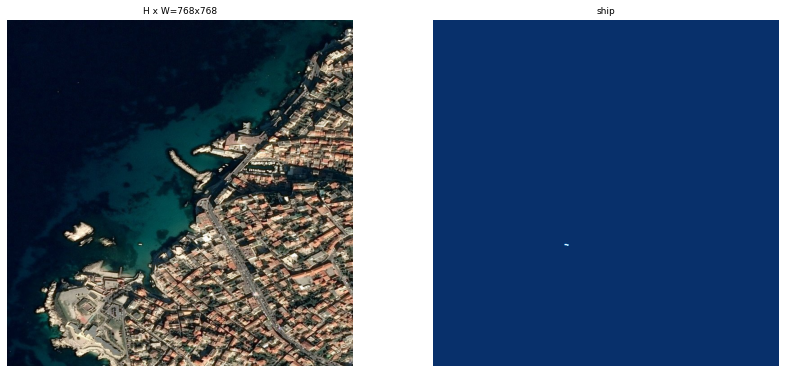

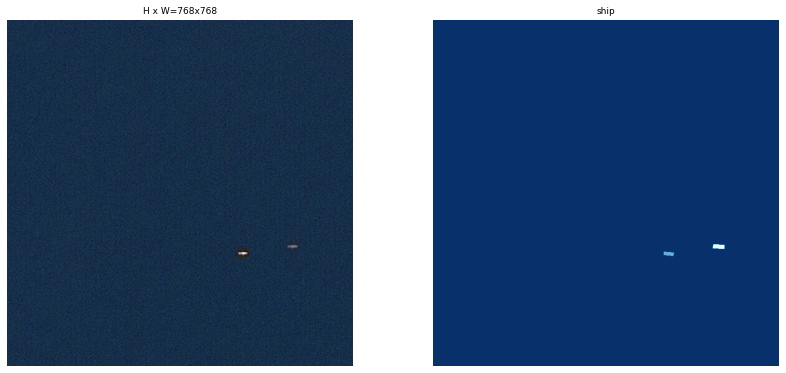

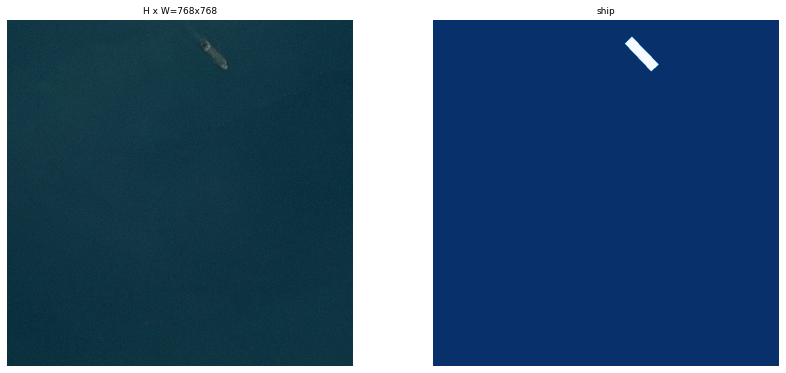

dataset prepare: 5.1171629428863525


In [13]:
start_time = time.time()
dataset_train = AirbusShipDetectionChallengeDataset(image_file_dir=TRAIN_DATA_PATH, ids=train_ids, masks=masks)
dataset_train.prepare()
dataset_val = AirbusShipDetectionChallengeDataset(image_file_dir=TRAIN_DATA_PATH, ids=val_ids, masks=masks)
dataset_val.prepare()

image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

end_time = time.time() - start_time
print("dataset prepare: {}".format(end_time))

## Load pre-trained wieghts
Pre-trained weights for MS COCO is loaded to provide a better straing point for training. 

In [86]:
start_time = time.time()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=WORKING_DIR)

import errno
try:
    weights_path = model.find_last()
    load_weights = True
except FileNotFoundError:
    load_weights = True
    weights_path = COCO_WEIGHTS_PATH
    utils.download_trained_weights(weights_path)
    
if load_weights:
    print("Loading weights: ", weights_path)
    model.load_weights(weights_path, by_name=True, exclude=[
                "mrcnn_class_logits", "mrcnn_bbox_fc",
                "mrcnn_bbox", "mrcnn_mask"])

end_time = time.time() - start_time
print("loading weights: {}".format(end_time))

AttributeError: module 'tensorflow' has no attribute 'random_shuffle'

# Train the model

In [ ]:

start_time = time.time()    
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE * 1.5,
            epochs=5,
            layers='all')
end_time = time.time() - start_time
print("Train model: {}".format(end_time))

# Inference


In [ ]:
class InferenceConfig(AirbusShipDetectionChallengeGPUConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
infer_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=WORKING_DIR)

model_path = infer_model.find_last()

print("Loading weights from ", model_path)
infer_model.load_weights(model_path, by_name=True)

image_id = np.random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = infer_model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

image_ids = np.random.choice(dataset_val.image_ids, 20)
APs = []
inference_start = time.time()
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    results = infer_model.detect([image], verbose=1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

inference_end = time.time()
print('Inference Time: %0.2f Minutes'%((inference_end - inference_start)/60))
print("mAP: ", np.mean(APs))
